# Evaluate the corner only with the track coordinate

In [150]:
import numpy as np
import fastf1
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd 

In [151]:
# Load Silverstone track data
session = fastf1.get_session(2023, 'Silverstone', 'Q')
session.load()

lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

circuit_info = session.get_circuit_info()


core           INFO 	Loading data for British Grand Prix - Qualifying [v3.4.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '55', '63', '44', '23', '14', '10', '27', '18', '31', '2', '77', '11', '22', '24', '21', '20']


In [152]:
type(circuit_info.corners)

pandas.core.frame.DataFrame

In [153]:
# Get X and Y coordinates
x = pos['X'].to_numpy()
y = pos['Y'].to_numpy()

In [154]:
# Define distances along the track for interpolation
distances = np.sqrt(np.diff(x)**2 + np.diff(y)**2).cumsum()
distances = np.insert(distances, 0, 0)  # Add 0 for the starting point

In [155]:
# Interpolate uniformly along the distances
uniform_distances = np.linspace(0, distances[-1], 500)  # Resample to 500 points
interp_x = interp1d(distances, x, kind='linear')
interp_y = interp1d(distances, y, kind='linear')
uniform_x = interp_x(uniform_distances)
uniform_y = interp_y(uniform_distances)

In [156]:
# Calculate angles between consecutive segments of the interpolated points
angles = []
for i in range(len(uniform_x) - 2):
    v1 = np.array([uniform_x[i+1] - uniform_x[i], uniform_y[i+1] - uniform_y[i]])
    v2 = np.array([uniform_x[i+2] - uniform_x[i+1], uniform_y[i+2] - uniform_y[i+1]])
    angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
    angle = np.degrees(angle)
    angles.append((angle + 180) % 360 - 180)

In [157]:
# Get median and IQR
abs_angles = np.abs(angles)
median_angle = np.median(abs_angles)
q1, q3 = np.percentile(abs_angles, [30, 70])
iqr = q3 - q1

In [158]:
max_val = 1
min_val = 0
# Normalize angles based on IQR, capped at the 25th and 75th percentiles
angle_intensities = [(angle - (median_angle - 0.5 * iqr)) / iqr for angle in abs_angles]
angle_intensities = np.clip(angle_intensities, min_val, max_val)  # Clamp between 0 and 1

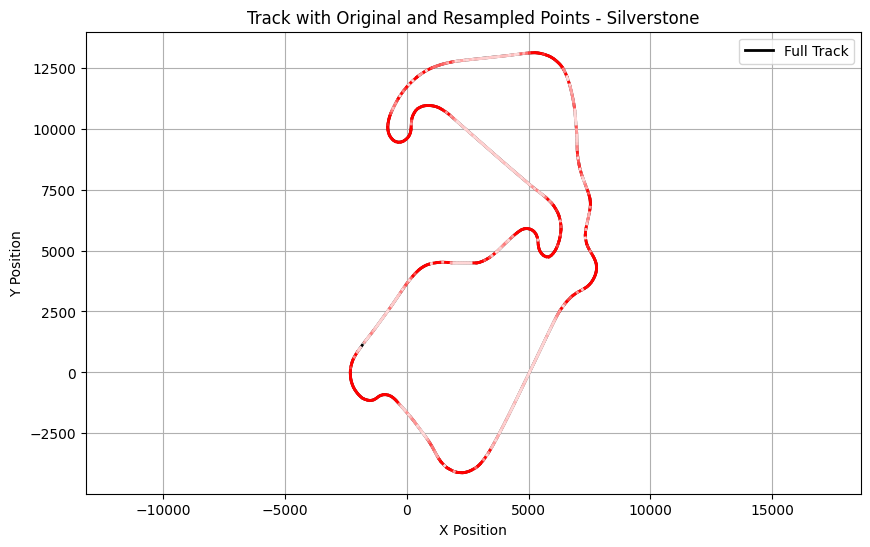

In [159]:
# Plot with new color intensities
plt.figure(figsize=(10, 6))
plt.plot(uniform_x, uniform_y, color='black', linewidth=2, label='Full Track')

for i in range(len(angles)):
    intensity = angle_intensities[i]
    color = (1, 1 - intensity, 1 - intensity)
    plt.plot(uniform_x[i:i+2], uniform_y[i:i+2], color=color, linewidth=2)

plt.title('Track with Original and Resampled Points - Silverstone')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

# Draw the corner on the track 

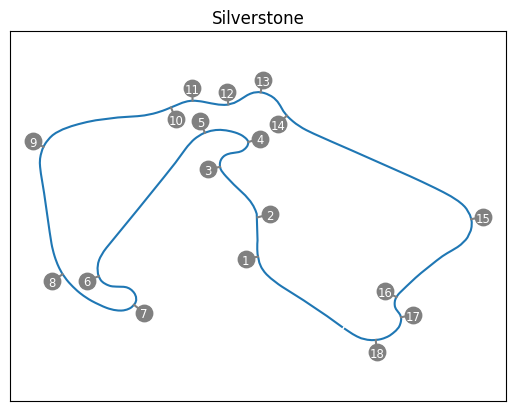

In [160]:
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

# Get an array of shape [n, 2] where n is the number of points and the second
# axis is x and y.
track = pos.loc[:, ('X', 'Y')].to_numpy()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate and plot the track map.
rotated_track = rotate(track, angle=track_angle)
plt.plot(rotated_track[:, 0], rotated_track[:, 1])

offset_vector = [500, 0]  # offset length is chosen arbitrarily to 'look good'

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')

plt.title(session.event['Location'])
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()


# Choose point before and after the corner 

In [161]:
import numpy as np
import fastf1
import matplotlib.pyplot as plt

# Load Silverstone track data
session = fastf1.get_session(2023, 'Silverstone', 'Q')
session.load()

# Get position data from the fastest lap
lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

# Get circuit information
circuit_info = session.get_circuit_info()

# Access the corners DataFrame
corner_df = circuit_info.corners[['X', 'Y', 'Number']]

# Choose a specific corner to analyze (for example, the first corner)
corner_index = 0  # Change this to the desired corner number
row = corner_df.iloc[corner_index]
corner_x = row['X']
corner_y = row['Y']

core           INFO 	Loading data for British Grand Prix - Qualifying [v3.4.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '55', '63', '44', '23', '14', '10', '27', '18', '31', '2', '77', '11', '22', '24', '21', '20']


In [162]:

# Get the closest points in the position data for the corner
distances = np.sqrt((pos['X'] - corner_x) ** 2 + (pos['Y'] - corner_y) ** 2)
nearest_indices = np.argsort(distances)[:6]  # Get the three closest points

# Select the corner points based on the nearest indices
corner_points = pos.iloc[nearest_indices]


In [163]:
print(corner_x,corner_y)

1192.50830078125 4503.826171875


In [164]:
# Calculate distances from the corner
distances = np.sqrt((pos['X'] - corner_x) ** 2 + (pos['Y'] - corner_y) ** 2)

In [165]:
# Get the index of the closest point to the corner
corner_index = np.argmin(distances)

In [166]:
# Determine the range for points before and after the corner
before_points = pos.iloc[max(corner_index - 3, 0):corner_index]  # First 10 points before the corner
after_points = pos.iloc[corner_index + 1:corner_index + 4]  # First 10 points after the corner

In [167]:
# Combine before and after points
corner_points = pd.concat([before_points, after_points])

# Optionally, you can print or visualize the selected points
print(corner_points)

                      Date   Status     X     Y     Z Source  \
18 2023-07-08 15:14:19.704  OnTrack   722  4362  2013    pos   
19 2023-07-08 15:14:19.804  OnTrack   781  4391  2013    pos   
20 2023-07-08 15:14:20.024  OnTrack   951  4456  2014    pos   
22 2023-07-08 15:14:20.684  OnTrack  1495  4520  2019    pos   
23 2023-07-08 15:14:20.944  OnTrack  1709  4511  2022    pos   
24 2023-07-08 15:14:21.105  OnTrack  1840  4497  2024    pos   

                     Time            SessionTime  
18 0 days 00:00:04.985000 0 days 01:29:19.701000  
19 0 days 00:00:05.085000 0 days 01:29:19.801000  
20 0 days 00:00:05.305000 0 days 01:29:20.021000  
22 0 days 00:00:05.965000 0 days 01:29:20.681000  
23 0 days 00:00:06.225000 0 days 01:29:20.941000  
24 0 days 00:00:06.386000 0 days 01:29:21.102000  


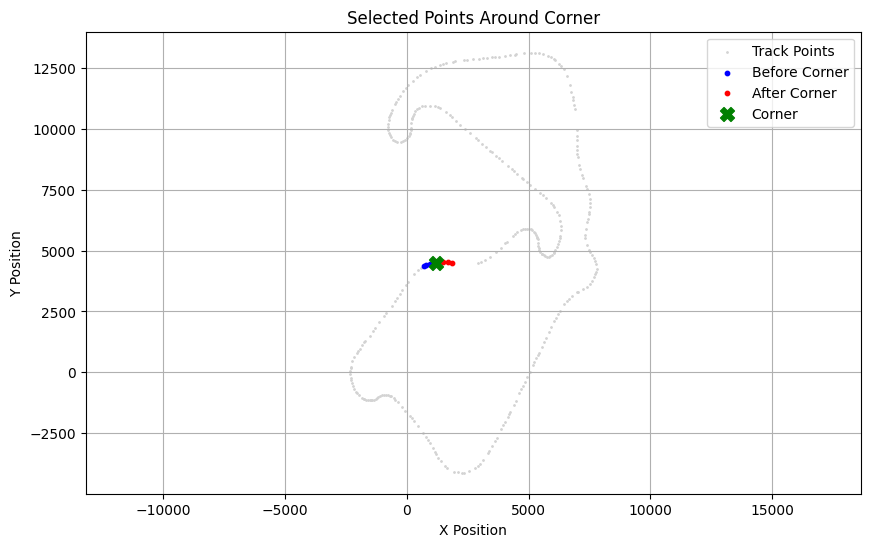

In [168]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(pos['X'], pos['Y'], color='lightgray', s=1, label='Track Points')  # All track points
plt.scatter(before_points['X'], before_points['Y'], color='blue', label='Before Corner', s=10)
plt.scatter(after_points['X'], after_points['Y'], color='red', label='After Corner', s=10)

plt.scatter(corner_x, corner_y, color='green', label='Corner', s=100, marker='X')  # Corner point
plt.title('Selected Points Around Corner')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()


# Create regression with the coordinate before the corner and the coordinate after the corner and evaluate the angle between the two regression to categorize the corner V1

In [169]:
import numpy as np
import pandas as pd
import fastf1
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load Silverstone track data
session = fastf1.get_session(2023, 'Silverstone', 'Q')
session.load()

# Get position data from the fastest lap
lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

# Get circuit information
circuit_info = session.get_circuit_info()

# Access the corners DataFrame
corner_df = circuit_info.corners[['X', 'Y', 'Number']]

# Choose a specific corner to analyze (for example, the first corner)
corner_number = 0  # Change this to the desired corner number
row = corner_df.iloc[corner_number]
corner_x = row['X']
corner_y = row['Y']

# Get the index of the closest point to the corner
corner_index = np.argmin(distances)

core           INFO 	Loading data for British Grand Prix - Qualifying [v3.4.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '55', '63', '44', '23', '14', '10', '27', '18', '31', '2', '77', '11', '22', '24', '21', '20']


In [170]:
# number of point used 
max_value = 10

# Determine the range for points before and after the corner
before_points = pos.iloc[max(corner_index - max_value, 0):corner_index]  # First 10 points before the corner
after_points = pos.iloc[corner_index + 1:corner_index + max_value +1]  # First 10 points after the corner

# Specific point through which the line should pass
x0, y0 = corner_x, corner_y  

# Prepare data for linear regression (X needs to be a 2D array)
X_before = before_points['X'].values.reshape(-1, 1)
y_before = before_points['Y'].values

X_after = after_points['X'].values.reshape(-1, 1)
y_after = after_points['Y'].values

In [172]:
# Fit a linear regression model to the points before the corner
model_before = LinearRegression()
model_before.fit(X_before, y_before)

# Calculate the fitted line
fitted_Y_before = model_before.coef_[0] * (X_before - x0) + y0

# Fit a linear regression model to the points after the corner
model_after = LinearRegression()
model_after.fit(X_after, y_after)

# Calculate the fitted line
fitted_Y_after = model_after.coef_[0] * (X_after - x0) + y0

# Generate extended points for the fitted line
longer_line = 3000

# Extend the range of x_fit_before and x_fit_after further
x_fit_before = np.linspace(X_before.min() - longer_line, X_before.max() + longer_line, 100).reshape(-1, 1)
y_fit_before = model_before.predict(x_fit_before)

x_fit_after = np.linspace(X_after.min() - longer_line, X_after.max() + longer_line, 100).reshape(-1, 1)
y_fit_after = model_after.predict(x_fit_after)

In [173]:
# Calculate the slopes of the two lines
slope_before = model_before.coef_[0]
slope_after = model_after.coef_[0]

# Calculate the acute angle between the two lines in radians
angle_radians = np.arctan(abs((slope_after - slope_before) / (1 + slope_before * slope_after)))

# Convert acute angle to degrees
acute_angle_degrees = np.degrees(angle_radians)

# Calculate the obtuse angle
obtuse_angle_degrees = 180 - acute_angle_degrees

print("The acute angle between the two lines is:", acute_angle_degrees, "degrees")
print("The obtuse angle between the two lines is:", obtuse_angle_degrees, "degrees")


The acute angle between the two lines is: 31.877976450578064 degrees
The obtuse angle between the two lines is: 148.12202354942193 degrees


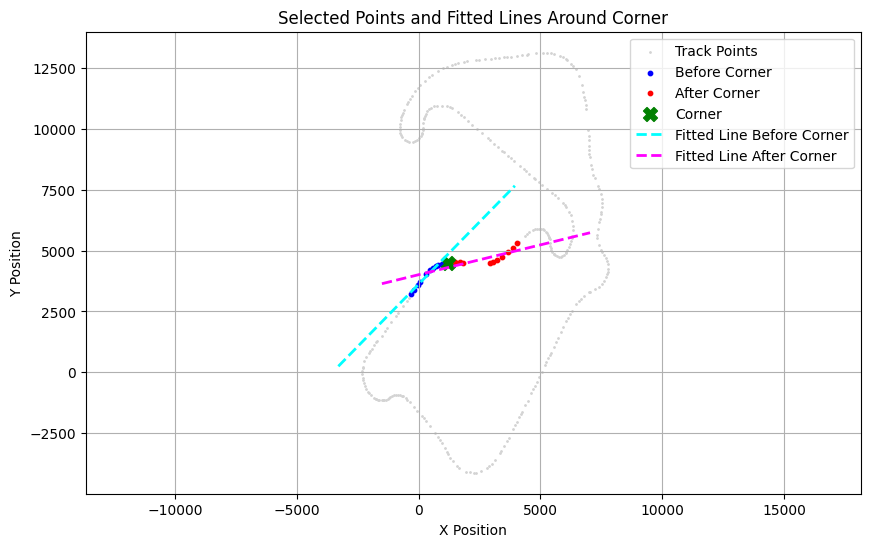

In [174]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(pos['X'], pos['Y'], color='lightgray', s=1, label='Track Points')  # All track points
plt.scatter(before_points['X'], before_points['Y'], color='blue', label='Before Corner', s=10)
plt.scatter(after_points['X'], after_points['Y'], color='red', label='After Corner', s=10)

# Plot the corner point
plt.scatter(corner_x, corner_y, color='green', label='Corner', s=100, marker='X')  # Corner point

# Plot the fitted lines with new colors
plt.plot(x_fit_before, y_fit_before, color='cyan', linestyle='--', linewidth=2, label='Fitted Line Before Corner')
plt.plot(x_fit_after, y_fit_after, color='magenta', linestyle='--', linewidth=2, label='Fitted Line After Corner')

plt.title('Selected Points and Fitted Lines Around Corner')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Create regression with the coordinate before the corner and the coordinate after the corner and evaluate the angle between the two regression to categorize the corner 2

In [175]:
import numpy as np
import pandas as pd
import fastf1
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load Silverstone track data
session = fastf1.get_session(2023, 'Silverstone', 'Q')
session.load()

# Get position data from the fastest lap
lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

# Get circuit information
circuit_info = session.get_circuit_info()

# Access the corners DataFrame
corner_df = circuit_info.corners[['X', 'Y', 'Number']]

# Choose a specific corner to analyze (for example, the first corner)
corner_number = 0  # Change this to the desired corner number
row = corner_df.iloc[corner_number]
corner_x = row['X']
corner_y = row['Y']

# Get the index of the closest point to the corner
corner_index = np.argmin(distances)

core           INFO 	Loading data for British Grand Prix - Qualifying [v3.4.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '55', '63', '44', '23', '14', '10', '27', '18', '31', '2', '77', '11', '22', '24', '21', '20']


In [ ]:
# Parameters
max_value = 10
longer_line = 2000

# Determine the range for points before and after the corner
before_points = pos.iloc[max(corner_index - max_value, 0):corner_index]  # First 10 points before the corner
after_points = pos.iloc[corner_index + 1:corner_index + max_value + 1]  # First 10 points after the corner

# Specific point through which the line should pass
x0, y0 = corner_x, corner_y

In [177]:
# Prepare data for linear regression (X needs to be a 2D array)
X_before = before_points['X'].values.reshape(-1, 1)
y_before = before_points['Y'].values

X_after = after_points['X'].values.reshape(-1, 1)
y_after = after_points['Y'].values

In [178]:
# Adjust X values for each segment to pass through (x0, y0)
adjusted_X_before = X_before - x0
adjusted_X_after = X_after - x0

In [179]:
# Fit a linear regression model to the points before the corner
model_before = LinearRegression()
model_before.fit(adjusted_X_before, y_before)
fitted_Y_before = model_before.coef_[0] * (X_before - x0) + y0

# Fit a linear regression model to the points after the corner
model_after = LinearRegression()
model_after.fit(adjusted_X_after, y_after)
fitted_Y_after = model_after.coef_[0] * (X_after - x0) + y0

In [ ]:
# Extend the range of x_fit_before and x_fit_after further
x_fit_before = np.linspace(X_before.min() - longer_line, X_before.max(), 100).reshape(-1, 1)
x_fit_after = np.linspace(X_after.min(), X_after.max() + longer_line, 100).reshape(-1, 1)

# Calculate the fitted lines with the constraint
y_fit_before = model_before.coef_[0] * (x_fit_before - x0) + y0
y_fit_after = model_after.coef_[0] * (x_fit_after - x0) + y0

In [181]:
# Calculate the slopes of the two lines
slope_before = model_before.coef_[0]
slope_after = model_after.coef_[0]

In [ ]:
# Calculate the acute angle between the two lines in radians
angle_radians = np.arctan(abs((slope_after - slope_before) / (1 + slope_before * slope_after)))

# Convert acute angle to degrees
acute_angle_degrees = np.degrees(angle_radians)

# Calculate the obtuse angle
obtuse_angle_degrees = 180 - acute_angle_degrees

The acute angle between the two lines is: 31.877976450578064 degrees
The obtuse angle between the two lines is: 148.12202354942193 degrees


The acute angle between the two lines is: 31.877976450578064 degrees
The obtuse angle between the two lines is: 148.12202354942193 degrees


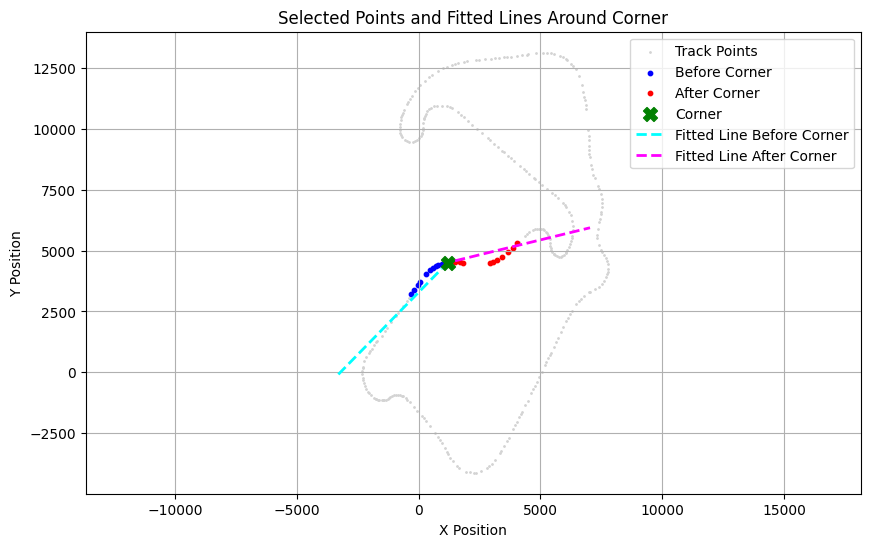

In [185]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(pos['X'], pos['Y'], color='lightgray', s=1, label='Track Points')  # All track points
plt.scatter(before_points['X'], before_points['Y'], color='blue', label='Before Corner', s=10)
plt.scatter(after_points['X'], after_points['Y'], color='red', label='After Corner', s=10)

# Plot the corner point
plt.scatter(corner_x, corner_y, color='green', label='Corner', s=100, marker='X')  # Corner point

print("The acute angle between the two lines is:", acute_angle_degrees, "degrees")
print("The obtuse angle between the two lines is:", obtuse_angle_degrees, "degrees")

# Plot the fitted lines with new colors
plt.plot(x_fit_before, y_fit_before, color='cyan', linestyle='--', linewidth=2, label='Fitted Line Before Corner')
plt.plot(x_fit_after, y_fit_after, color='magenta', linestyle='--', linewidth=2, label='Fitted Line After Corner')

plt.title('Selected Points and Fitted Lines Around Corner')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Constrained Linear Regression Before and After Corner test

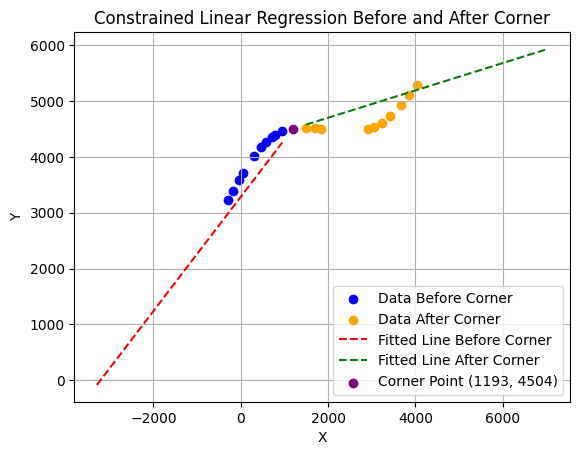

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Parameters
max_value = 10
longer_line = 3000

# Determine the range for points before and after the corner
before_points = pos.iloc[max(corner_index - max_value, 0):corner_index]  # First 10 points before the corner
after_points = pos.iloc[corner_index + 1:corner_index + max_value + 1]  # First 10 points after the corner

# Specific point through which the line should pass
x0, y0 = corner_x, corner_y

# Prepare data for linear regression (X needs to be a 2D array)
X_before = before_points['X'].values.reshape(-1, 1)
y_before = before_points['Y'].values

X_after = after_points['X'].values.reshape(-1, 1)
y_after = after_points['Y'].values

# Adjust X values for each segment to pass through (x0, y0)
adjusted_X_before = X_before - x0
adjusted_X_after = X_after - x0

# Fit a linear regression model to the points before the corner
model_before = LinearRegression()
model_before.fit(adjusted_X_before, y_before)
fitted_Y_before = model_before.coef_[0] * (X_before - x0) + y0

# Fit a linear regression model to the points after the corner
model_after = LinearRegression()
model_after.fit(adjusted_X_after, y_after)
fitted_Y_after = model_after.coef_[0] * (X_after - x0) + y0

# Extend the range of x_fit_before and x_fit_after further
x_fit_before = np.linspace(X_before.min() - longer_line, X_before.max(), 100).reshape(-1, 1)
x_fit_after = np.linspace(X_after.min(), X_after.max() + longer_line, 100).reshape(-1, 1)

# Calculate the fitted lines with the constraint
y_fit_before = model_before.coef_[0] * (x_fit_before - x0) + y0
y_fit_after = model_after.coef_[0] * (x_fit_after - x0) + y0

# Plot the data points and the constrained regression lines
plt.scatter(X_before, y_before, color='blue', label='Data Before Corner')
plt.scatter(X_after, y_after, color='orange', label='Data After Corner')
plt.plot(x_fit_before, y_fit_before, color='red', linestyle='--', label='Fitted Line Before Corner')
plt.plot(x_fit_after, y_fit_after, color='green', linestyle='--', label='Fitted Line After Corner')
plt.scatter(x0, y0, color='purple', label=f'Corner Point ({round(x0)}, {round(y0)})', zorder=5)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Constrained Linear Regression Before and After Corner")
plt.grid(True)
plt.show()


# interpolate data to have equal step 

core           INFO 	Loading data for British Grand Prix - Qualifying [v3.4.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '55', '63', '44', '23', '14', '10', '27', '18', '31', '2', '77', '11', '22', '24', '21', '20']


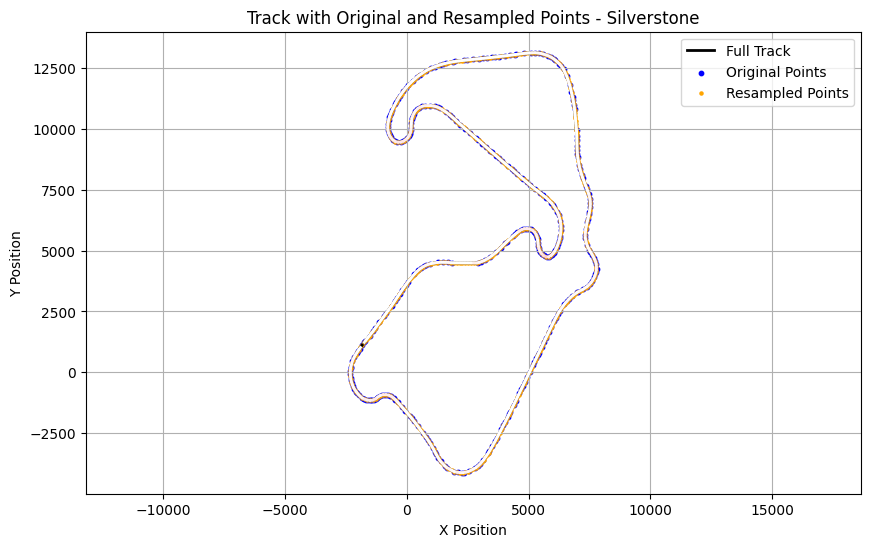

In [ ]:
import numpy as np
import fastf1
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load Silverstone track data
session = fastf1.get_session(2023, 'Silverstone', 'Q')
session.load()

lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

# Get X and Y coordinates
x = pos['X'].to_numpy()
y = pos['Y'].to_numpy()

# Define distances along the track for interpolation
distances = np.sqrt(np.diff(x)**2 + np.diff(y)**2).cumsum()
distances = np.insert(distances, 0, 0)  # Add 0 for the starting point

# Number of resample point 
nb_point = 500


# Interpolate uniformly along the distances
uniform_distances = np.linspace(0, distances[-1], nb_point)  # Resample to 500 points
interp_x = interp1d(distances, x, kind='linear')
interp_y = interp1d(distances, y, kind='linear')
uniform_x = interp_x(uniform_distances)
uniform_y = interp_y(uniform_distances)

# Calculate angles between consecutive segments of the interpolated points
angles = []
for i in range(len(uniform_x) - 2):
    v1 = np.array([uniform_x[i+1] - uniform_x[i], uniform_y[i+1] - uniform_y[i]])
    v2 = np.array([uniform_x[i+2] - uniform_x[i+1], uniform_y[i+2] - uniform_y[i+1]])
    angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
    angle = np.degrees(angle)
    angles.append((angle + 180) % 360 - 180)

# Plot the full track in a neutral color
plt.figure(figsize=(10, 6))

plt.plot(uniform_x, uniform_y, color='black', linewidth=2, label='Full Track')

# Color the track based on angles
for i in range(len(angles)):
    angle_intensity = abs(angles[i]) / 180  # Normalize for color intensity
    color = (1, 1 - angle_intensity, 1 - angle_intensity)  # Red intensity based on angle
    plt.plot(uniform_x[i:i+2], uniform_y[i:i+2], color=color, linewidth=2)

# Mark original and resampled points
plt.scatter(x, y, color='blue', s=10, label='Original Points')  # Original data points
plt.scatter(uniform_x, uniform_y, color='orange', s=5, label='Resampled Points')  # Resampled points

plt.title('Track with Original and Resampled Points - Silverstone')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()


# Graph of all the corner

/tmp/ipykernel_7879/2794928285.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


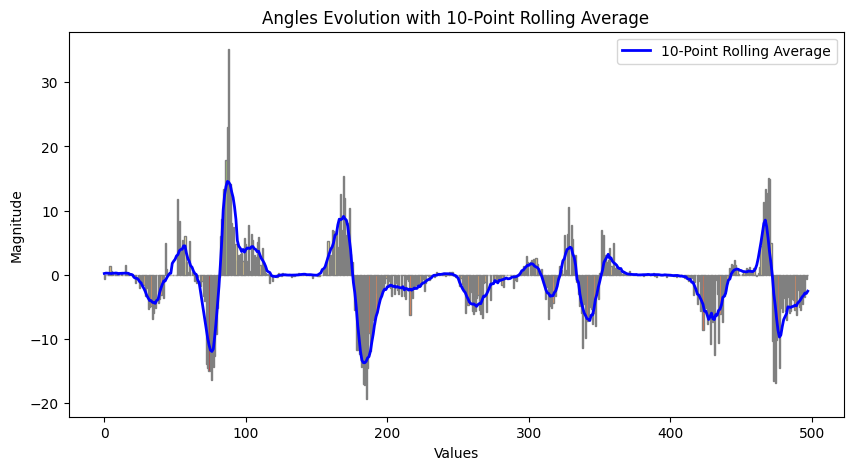

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Sample list of values
values = angles

# Normalize the values to the range [0, 1]
min_val = min(values)
max_val = max(values)
normalized_values = [(value - min_val) / (max_val - min_val) for value in values]

# Create a colormap (e.g., 'viridis', 'plasma', 'RdYlGn', etc.)
cmap = cm.get_cmap('RdYlGn')

# Map normalized values to colors
colors = [cmap(norm_val) for norm_val in normalized_values]

rolling_avg_step = 10

# Calculate the rolling average over 5 points
rolling_avg = pd.Series(values).rolling(window=rolling_avg_step,center=True, min_periods=1).mean()

# Plotting the values with the corresponding colors
plt.figure(figsize=(10, 5))
for i, value in enumerate(values):
    plt.bar(i, value, color=colors[i], edgecolor='grey')

# Plot the rolling average line
plt.plot(rolling_avg, color='blue', linewidth=2, label=f'{rolling_avg_step}-Point Rolling Average')

# Adding titles and labels
plt.title(f'Angles Evolution with {rolling_avg_step}-Point Rolling Average')
plt.xlabel('Values')
plt.ylabel('Magnitude')
plt.legend()
plt.show()


# exemple of use of linecollection 

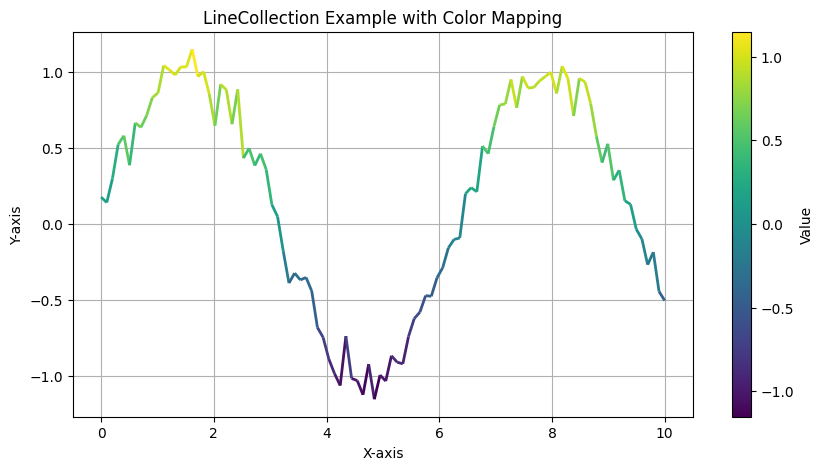

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Generate some example data
np.random.seed(0)  # For reproducibility
n_lines = 100
x = np.linspace(0, 10, n_lines)
y = np.sin(x) + np.random.normal(scale=0.1, size=n_lines)  # Noisy sine wave

# Create segments for LineCollection
points = np.array([x, y]).T.reshape(-1, 1, 2)  # Reshape for LineCollection
segments = np.concatenate([points[:-1], points[1:]], axis=1)  # Create pairs of points

# Normalize values for color mapping
norm = plt.Normalize(y.min(), y.max())
colors = plt.cm.viridis(norm(y))  # Map values to colors

# Create a LineCollection
line_collection = LineCollection(segments, cmap='viridis', norm=norm, linewidths=2)
line_collection.set_array(y)  # Use y values for color mapping

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.add_collection(line_collection)  # Add LineCollection to the axes
ax.autoscale_view()  # Automatically scale axes to fit the data

# Add colorbar
cb = plt.colorbar(line_collection, ax=ax)
cb.set_label('Value')

# Set labels and title
plt.title('LineCollection Example with Color Mapping')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()
